In [37]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

In [38]:
import functools

import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab


DC_params = {'nh' : 1e4, 'T': 10., 'Chi': 1e-4, 'xh': 0., 'xC': 1e-6, 'y' : 0.999,  'gamma': 0, 'dipole': 9.3, 'line':7}

MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3, 'line':7}    

CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WNM_params = {'nh' : 0.4, 'T': 6000., 'Chi': 1., 'xh': 0.1, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WIM_params = {'nh' : 0.1, 'T': 8000., 'Chi': 1., 'xh': 0.99, 'xC': 1e-3, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

RN_params = {'nh' : 1000., 'T': 100., 'Chi': 1000., 'xh': 0.001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

PDR_params = {'nh' : 1e5, 'T': 300., 'Chi': 3000., 'xh': 0.0001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

a_min=3.5e-8
a2=6.0e-8
a_max=3.5e-7

a_tab = makelogtab(a_min, a_max, 80)

beta_tab_cylinder = np.linspace(-0.48, -0.2, 40)
beta_tab_ellip = np.linspace(-0.2, 0.2, 40)

def cache_last_call(func):
    last_args = {"args": None, "kwargs": None, "result": None}

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Compare with last args
        if (last_args["args"] is not None 
            and len(args) == len(last_args["args"]) 
            and all(np.array_equal(a, b) if isinstance(a, np.ndarray) else a == b
                    for a, b in zip(args, last_args["args"])) 
            and kwargs == last_args["kwargs"]):
            return last_args["result"]

        # Otherwise, compute new
        result = func(*args, **kwargs)
        last_args["args"] = args
        last_args["kwargs"] = kwargs
        last_args["result"] = result
        return result

    return wrapper

@cache_last_call
def generate_same_grains_SED(env, a, beta, a2):
    # if "a" is a number, return a single SED result; if "a" is a table, return a table of SED results
    if isinstance(a, (int, float)):
        result = SpyDust_given_grain_size_shape(env, a, beta, 
                                                min_freq=0.1, max_freq=100.0, n_freq=200,
                                                N_angular_Omega=500,
                                                a2=a2)
        result_SED = result[1]
    else:
        result_SED = []
        for a_val in a:
            result = SpyDust_given_grain_size_shape(env, a_val, beta, 
                                                min_freq=0.1, max_freq=100.0, n_freq=200,
                                                N_angular_Omega=500,
                                                a2=a2)
            result_SED.append(result[1])
        result_SED = np.array(result_SED)

    freqs = result[0]
    return freqs, result_SED

def SED_list_given_SSE(a_beta_tab, env, a2):   
    # generate the SED list given the tables of grain size (S) a_tab, grain shape (S) beta_tab, and the environment (E)
    SED_list = []
    from tqdm import tqdm
    for a, beta in tqdm(a_beta_tab):
        freqs, result = generate_same_grains_SED(env, a, beta, a2=a2)
        SED_list.append(result)
    return freqs,np.array(SED_list)

In [39]:
env = CNM_params
beta_tab = beta_tab_ellip
a_beta_tab_ellip = np.array(np.meshgrid(a_tab, beta_tab)).T.reshape(-1, 2)

freqs, CNM_SEDs_ellip =  SED_list_given_SSE(a_beta_tab_ellip, env, 
                                            a2=a_min*0.9) # all grains are ellipsoidal


100%|██████████| 3200/3200 [08:41<00:00,  6.14it/s]


In [40]:
env = CNM_params
beta_tab = beta_tab_cylinder
a_beta_tab_disk = np.array(np.meshgrid(a_tab, beta_tab)).T.reshape(-1, 2)
freqs, CNM_SEDs_disk =  SED_list_given_SSE(a_beta_tab_disk, env, a2=a_max*1.1) # all grains are disk-shaped


100%|██████████| 3200/3200 [10:26<00:00,  5.10it/s]


In [41]:
np.save('CNM_SEDs_ellip.npy', CNM_SEDs_ellip)
np.save('CNM_SEDs_disk.npy', CNM_SEDs_disk)
np.save('freqs.npy', freqs)


In [42]:
from SpyDust.SED_fit import fit_sed_ensemble

In [43]:
CNM_features_ellip =  fit_sed_ensemble(freqs, CNM_SEDs_ellip, thres=1e-3, v2=False)

100%|██████████| 3200/3200 [00:00<00:00, 6536.51it/s]


In [44]:
CNM_features_disk =  fit_sed_ensemble(freqs, CNM_SEDs_disk, thres=1e-3, v2=False)


100%|██████████| 3200/3200 [00:00<00:00, 6584.03it/s]


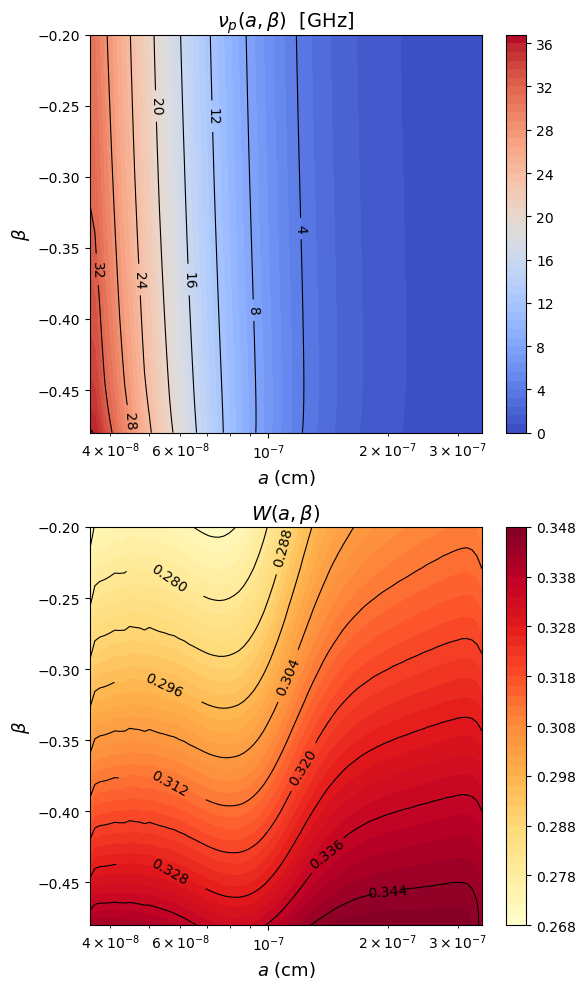

In [45]:
import numpy as np
import matplotlib.pyplot as plt

a_beta_tab = a_beta_tab_disk
features = CNM_features_disk


X = a_beta_tab.reshape(80,40,2)[:, :, 0]
Y = a_beta_tab.reshape(80,40,2)[:, :, 1]
Z1 = np.exp(features.reshape(80,40,2)[:, :, 0])
Z2 = features.reshape(80,40,2)[:, :, 1]

# -------------------------
# Create the plot
# -------------------------
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
ax = ax.flatten()

# Filled heatmap (smooth color shading)
# cmap = plt.cm.viridis
cmap = plt.cm.coolwarm
heat = ax[0].contourf(X, Y, Z1, levels=50, cmap=cmap)

# Contour lines (iso-values)
contours = ax[0].contour(X, Y, Z1, levels=8, colors='black', linewidths=0.8)
ax[0].clabel(contours, inline=True, fontsize=10, fmt="%.0f")

# Colorbar
cbar = fig.colorbar(heat, ax=ax[0])
# cbar.set_label("Function value", fontsize=12)
ax[0].set_xscale('log')

# Axis labels and style
ax[0].set_xlabel(r"$a$ (cm)", fontsize=13)
ax[0].set_ylabel(r"$\beta$", fontsize=13)
ax[0].set_title(fr"$\nu_p(a, \beta)$  [GHz]", fontsize=14)
ax[0].tick_params(labelsize=10)

cmap = plt.cm.YlOrRd
heat = ax[1].contourf(X, Y, Z2, levels=50, cmap=cmap)
contours = ax[1].contour(X, Y, Z2, levels=10, colors='black', linewidths=0.8)
# ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f",
#             rightside_up=True, inline_spacing=15)

ax[1].margins(0.05)  # Small margin
levels_to_label = contours.levels[1:-1] if len(contours.levels) > 2 else contours.levels
ax[1].clabel(contours, levels=levels_to_label, inline=True, fontsize=10, fmt="%.3f",
             rightside_up=True)

ax[1].set_xscale('log')

cbar = fig.colorbar(heat, ax=ax[1], format="%.3f")
ax[1].set_xlabel(r"$a$ (cm)", fontsize=13)
ax[1].set_ylabel(r"$\beta$", fontsize=13)
ax[1].set_title(fr"$W(a, \beta)$", fontsize=14)
ax[1].tick_params(labelsize=10)

fig.tight_layout()

plt.savefig("CNM_feature_map_disk_given_size_shape.pdf", dpi=300)
plt.show()

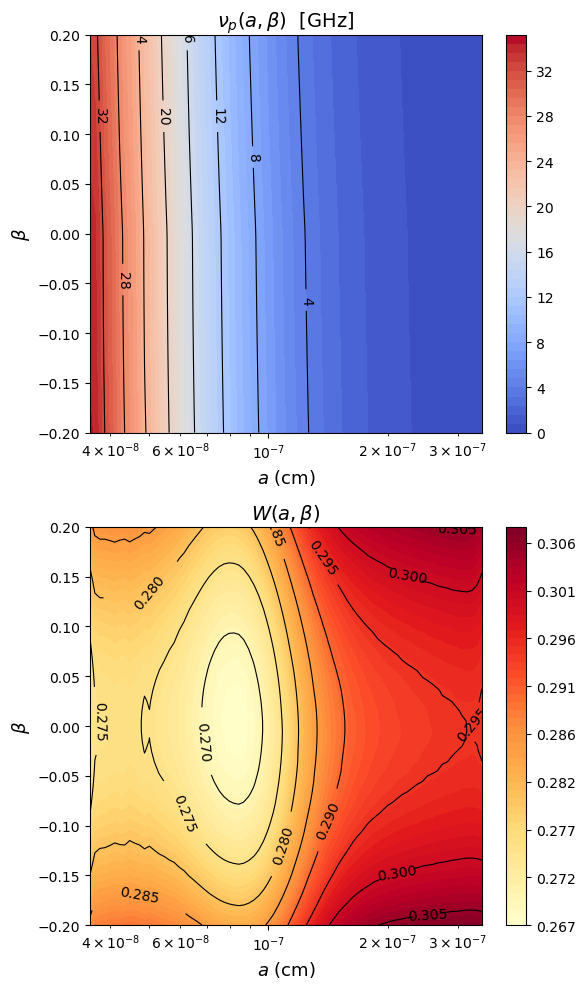

In [46]:
import numpy as np
import matplotlib.pyplot as plt

a_beta_tab = a_beta_tab_ellip
features = CNM_features_ellip


X = a_beta_tab.reshape(80,40,2)[:, :, 0]
Y = a_beta_tab.reshape(80,40,2)[:, :, 1]
Z1 = np.exp(features.reshape(80,40,2)[:, :, 0])
Z2 = features.reshape(80,40,2)[:, :, 1]

# -------------------------
# Create the plot
# -------------------------
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
ax = ax.flatten()

# Filled heatmap (smooth color shading)
# cmap = plt.cm.viridis
cmap = plt.cm.coolwarm
heat = ax[0].contourf(X, Y, Z1, levels=50, cmap=cmap)

# Contour lines (iso-values)
contours = ax[0].contour(X, Y, Z1, levels=8, colors='black', linewidths=0.8)
ax[0].clabel(contours, inline=True, fontsize=10, fmt="%.0f")

# Colorbar
cbar = fig.colorbar(heat, ax=ax[0])
# cbar.set_label("Function value", fontsize=12)
ax[0].set_xscale('log')

# Axis labels and style
ax[0].set_xlabel(r"$a$ (cm)", fontsize=13)
ax[0].set_ylabel(r"$\beta$", fontsize=13)
ax[0].set_title(fr"$\nu_p(a, \beta)$  [GHz]", fontsize=14)
ax[0].tick_params(labelsize=10)

cmap = plt.cm.YlOrRd
heat = ax[1].contourf(X, Y, Z2, levels=50, cmap=cmap)
contours = ax[1].contour(X, Y, Z2, levels=7, colors='black', linewidths=0.8)
# ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f",
#             rightside_up=True, inline_spacing=15)

ax[1].margins(0.05)  # Small margin
levels_to_label = contours.levels[1:-1] if len(contours.levels) > 2 else contours.levels
ax[1].clabel(contours, levels=levels_to_label, inline=True, fontsize=10, fmt="%.3f",
             rightside_up=True, inline_spacing=10)

ax[1].set_xscale('log')

cbar = fig.colorbar(heat, ax=ax[1], format="%.3f")
ax[1].set_xlabel(r"$a$ (cm)", fontsize=13)
ax[1].set_ylabel(r"$\beta$", fontsize=13)
ax[1].set_title(fr"$W(a, \beta)$", fontsize=14)
ax[1].tick_params(labelsize=10)

fig.tight_layout()

plt.savefig("CNM_feature_map_ellip_given_size_shape.pdf", dpi=300)
plt.show()

In [47]:
features.shape

(3200, 2)

# Emulator

In [15]:
from MomentEmu import PolyEmu

In [16]:
# Create emulator with both forward and inverse capabilities
CNM_feature_emu_small_single = PolyEmu(
    a_beta_tab_small, 
    CNM_features_small, 
    forward=True,              # Enable forward emulation: parameters → observables
    max_degree_forward=25,     # Max polynomial degree for forward mapping (lower for high-dimensional problems)
    RMSE_lower=0.01,
    fRMSE_tol=1e-1,
)

NameError: name 'a_beta_tab_small' is not defined

In [ ]:
import SpyDust.Grain as Grain


def eval_beta_arbitrary(a, d):
    if a <= a2:
        beta_val = Grain.cylindrical_params(a, d)[1]
    else:
        beta_val=0.
    return beta_val

def _normalise(w):
    """Turn any non–negative weight array into a PDF."""
    w = np.asarray(w, dtype=float)
    if np.any(w < 0):                       # sanity check
        raise ValueError("Weights must be non-negative.")
    s = w.sum()
    if s == 0:
        raise ValueError("All weights are zero → cannot normalise.")
    return w / s

a_list = np.concatenate((a_tab_cylinder, a_tab_ellip))

def grain_size_dist(gamma, log_a0, sigma):
    """
    dn/da propto exp[(gamma - 1) lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    equivalent to
    dn/dlna propto exp[gamma * lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    """
    ln_a_list = np.log(a_list)
    exponent = gamma  * ln_a_list - 0.5 * ( (ln_a_list - log_a0 + sigma**2/2) / sigma ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    dln_a_1 =  ln_a_list[1] - ln_a_list[0]
    dln_a_2 =  ln_a_list[-1] - ln_a_list[-2]
    dlna_list = np.concatenate(([dln_a_1]*40, [dln_a_2]*40))
    return _normalise(weights * dlna_list)

def grain_shape_dist(a, d, delta):
    beta_tab = beta_tab_cylinder
    ln_beta_t_tab = np.log( beta_tab + 0.5 )
    ln_beta_d_t = np.log( eval_beta_arbitrary(a, d) + 0.5 )
    exponent = - ln_beta_t_tab - 0.5 * ( (ln_beta_t_tab  - ln_beta_d_t + delta**2/2 ) / delta ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    return _normalise(weights)
    

In [ ]:

def generate_size_shape_dist(gamma, log_a0, sigma, d, delta):

    distr_a_beta_cylinder = np.zeros((len(a_tab_cylinder), len(beta_tab_cylinder)))

    distr_a = grain_size_dist(gamma, log_a0, sigma)
    distr_a_cylinder = distr_a[:40]
    distr_a_ellip = distr_a[40:]

    for i in range(len(a_tab_cylinder)):
        a = a_tab_cylinder[i]
        distr_a_beta_cylinder[i, :] = grain_shape_dist(a, d, delta) * distr_a_cylinder[i]

    return distr_a_beta_cylinder, distr_a_ellip

a_beta_tab_sphe = []
for a in a_tab_ellip:
    a_beta_tab_sphe.append([a, 0.])
a_beta_tab_sphe = np.array(a_beta_tab_sphe)

freqs, CNM_SEDs_sphe =  SED_list_given_SSE(a_beta_tab_sphe, CNM_params)

def synthesize_SED(gamma, log_a0, sigma, d, delta):
    distr_a_beta_cylinder, distr_a_ellip = generate_size_shape_dist(gamma, log_a0, sigma, d, delta)
    SED_cylin = np.sum(distr_a_beta_cylinder[:, :, np.newaxis] * CNM_SEDs_small.reshape(40,40,-1), 
                        axis=(0, 1))
    SED_ellip = np.sum(distr_a_ellip[:, np.newaxis] * CNM_SEDs_sphe, axis=0)
    return SED_cylin + SED_ellip

In [ ]:
# reference values of the parameters:
gamma_ref, log_a0_ref, sigma_ref, d_ref, delta_ref = 0., np.log(a2), 0.5, Grain.d, 0.01


In [ ]:
print(a_beta_tab_large[100])
measure_sed_peak_properties(freqs, CNM_SEDs_large[100], plot=True, save_path="SED_large_100_fit.pdf", thres=1e-3, title='SED of grains with $a=6.70\\, \\AA$ and $\\beta=-0.003$', v2=False)


In [ ]:
print(a_beta_tab_small[100])
measure_sed_peak_properties(freqs, CNM_SEDs_small[100], plot=True, save_path="SED_small_100_fit.pdf", thres=1e-3, title='SED of grains with $a=3.62\\, \\AA$ and $\\beta=-0.33$', v2=False)

In [ ]:
import importlib
import SpyDust.SED_fit
importlib.reload(SpyDust.SED_fit)
from SpyDust.SED_fit import measure_sed_peak_properties

SED_ref = synthesize_SED(gamma_ref, log_a0_ref, 0.1, d_ref, delta_ref)
measure_sed_peak_properties(freqs, SED_ref, plot=True, save_path="SED_eg_dist_fit.pdf", thres=1e-3, title='SED of an example size and shape distribution', v2=False)

In [ ]:

gamma_list = np.linspace(-2.5, 2, 100)
log_a0_list = np.linspace(np.log(a_min), np.log(a_max), 100)
sigma_list = makelogtab(0.01, 10, 100)
d_list = np.linspace(Grain.d/2, Grain.d*2, 100)
delta_list = makelogtab(0.001, 1, 100)


In [ ]:

SED_gamma_list = []
for gamma in gamma_list:
    SED_gamma_list.append(synthesize_SED(gamma, log_a0_ref, sigma_ref, d_ref, delta_ref))
SED_gamma_list = np.array(SED_gamma_list)

SED_log_a0_list = []
for log_a0 in log_a0_list:
    SED_log_a0_list.append(synthesize_SED(gamma_ref, log_a0, sigma_ref, d_ref, delta_ref))
SED_log_a0_list = np.array(SED_log_a0_list)

SED_sigma_list = []
for sigma in sigma_list:
    SED_sigma_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma, d_ref, delta_ref))
SED_sigma_list = np.array(SED_sigma_list)

SED_d_list = []
for d in d_list:
    SED_d_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d, delta_ref))
SED_d_list = np.array(SED_d_list)

SED_delta_list = []
for delta in delta_list:
    SED_delta_list.append(synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d_ref, delta))
SED_delta_list = np.array(SED_delta_list)


In [ ]:
SED_gamma_features = fit_sed_ensemble(freqs, SED_gamma_list)

SED_log_a0_features = fit_sed_ensemble(freqs, SED_log_a0_list)

SED_sigma_features = fit_sed_ensemble(freqs, SED_sigma_list)

SED_d_features = fit_sed_ensemble(freqs, SED_d_list)

SED_delta_features = fit_sed_ensemble(freqs, SED_delta_list)


In [ ]:
SED_ref = synthesize_SED(gamma_ref, log_a0_ref, sigma_ref, d_ref, delta_ref)

SED_ref_features = fit_sed_ensemble(freqs, SED_ref)

In [ ]:
SED_ref_features

In [ ]:
import matplotlib.pyplot as plt

# Create figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey='row')

# Define improved styling
curve_color = '#4A90E2'  # Light blue
curve_alpha = 0.7
curve_linewidth = 5
ref_color = '#2C3E50'  # Dark blue-gray
ref_linewidth = 2
ref_alpha = 0.9

# First row - nu_p [GHz] (exponential of first feature)
axes[0, 0].plot(gamma_list, np.exp(SED_gamma_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 0].set_xlabel(r'$\gamma$')
# show the reference value
axes[0, 0].axvline(gamma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 0].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 1].plot(log_a0_list - np.log(a2), np.exp(SED_log_a0_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 1].set_xlabel(r'$\ln{{(a_0 / a_\ast)}}$')
# show the reference value
axes[0, 1].axvline(log_a0_ref - np.log(a2), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 1].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 2].plot(sigma_list, np.exp(SED_sigma_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 2].set_xscale('log')
axes[0, 2].set_xlabel(r'$\sigma$')
# show the reference value
axes[0, 2].axvline(sigma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 2].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 3].plot(d_list/d_ref, np.exp(SED_d_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 3].set_xlabel(r'$d/d_\ast$')
axes[0, 3].set_xscale('log')
# show the reference value
axes[0, 3].axvline(1., color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 3].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[0, 4].plot(delta_list, np.exp(SED_delta_features[:, 0]), 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[0, 4].set_xscale('log')
axes[0, 4].set_xlabel(r'$\delta$')
# show the reference value
axes[0, 4].axvline(delta_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[0, 4].axhline(np.exp(SED_ref_features[0]), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

# Set shared y-label for first row
axes[0, 0].set_ylabel(r'$\nu_{\rm p}$ [GHz]')

# Second row - beta (second feature)
axes[1, 0].plot(gamma_list, SED_gamma_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 0].set_xlabel(r'$\gamma$')
axes[1, 0].axvline(gamma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 0].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 1].plot(log_a0_list - np.log(a2), SED_log_a0_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 1].set_xlabel(r'$\ln{{(a_0 / a_\ast)}}$')
# show the reference value
axes[1, 1].axvline(log_a0_ref - np.log(a2), color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 1].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 2].plot(sigma_list, SED_sigma_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 2].set_xscale('log')
axes[1, 2].set_xlabel(r'$\sigma$')
# show the reference value
axes[1, 2].axvline(sigma_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 2].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 3].plot(d_list / d_ref, SED_d_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 3].set_xlabel(r'$d/d_\ast$')
axes[1, 3].set_xscale('log')
# show the reference value
axes[1, 3].axvline(1., color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 3].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

axes[1, 4].plot(delta_list, SED_delta_features[:, 1], 
                color=curve_color, alpha=curve_alpha, linewidth=curve_linewidth)
axes[1, 4].set_xscale('log')
axes[1, 4].set_xlabel(r'$\delta$')
# show the reference value
axes[1, 4].axvline(delta_ref, color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)
axes[1, 4].axhline(SED_ref_features[1], color=ref_color, linestyle='--', 
                   linewidth=ref_linewidth, alpha=ref_alpha)

# Set shared y-label for second row
axes[1, 0].set_ylabel(r'$W$')

# Enhanced styling
font_size = 18
for ax in axes.flat:
    ax.tick_params(axis='both', which='both', labelsize=font_size)
    ax.set_title(ax.get_title(), fontsize=font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size)
    # Add subtle grid for better readability
    # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    # Improve spine appearance
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#34495E')

# Adjust layout and show
plt.tight_layout()
plt.savefig("SED_feature_given_distribution.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def grain_size_unweighted_dist(gamma, log_a0, sigma):
    """
    dn/da propto exp[(gamma - 1) lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    """
    a_aux_list = np.linspace(a_min, a_max, 200)
    ln_a_list = np.log(a_aux_list)
    exponent = (gamma-1)  * ln_a_list - 0.5 * ( (ln_a_list - log_a0 + sigma**2/2) / sigma ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    return _normalise(weights)

def grain_shape_dist(a, d, delta):
    beta_tab = beta_tab_cylinder
    ln_beta_t_tab = np.log( beta_tab + 0.5 )
    ln_beta_d_t = np.log( eval_beta_arbitrary(a, d) + 0.5 )
    exponent = - ln_beta_t_tab - 0.5 * ( (ln_beta_t_tab  - ln_beta_d_t + delta**2/2 ) / delta ) ** 2
    max_exponent = np.max(exponent)
    exponent -= max_exponent
    weights = np.exp(exponent)
    return _normalise(weights)
    
def generate_size_shape_dist(gamma, log_a0, sigma, d, delta):

    distr_a_beta = np.zeros((200, len(beta_tab_cylinder)))

    distr_a = grain_size_dist(gamma, log_a0, sigma)
    distr_a_cylinder = distr_a[:40]
    distr_a_ellip = distr_a[40:]

    for i in range(len(a_tab_cylinder)):
        a = a_tab_cylinder[i]
        distr_a_beta_cylinder[i, :] = grain_shape_dist(a, d, delta) * distr_a_cylinder[i]

    return distr_a_beta_cylinder, distr_a_ellip

In [ ]:
distr_1 = grain_size_unweighted_dist(gamma_ref, log_a0_ref, sigma_ref) # sigma = 0.5

distr_2 = grain_size_unweighted_dist(gamma_ref, log_a0_ref, 0.1) # sigma = 0.1

distr_3 = grain_size_unweighted_dist(gamma_ref, log_a0_ref, 2) # sigma = 2


In [ ]:
a_aux_list = np.linspace(a_min, a_max, 200)

# Create a single figure with all three distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot all three distributions on the same panel
ax.loglog(a_aux_list, distr_1, 'b-', linewidth=2, label=r'distr_1 ($\sigma = 0.5$)')
ax.loglog(a_aux_list, distr_2, 'r-', linewidth=2, label=r'distr_2 ($\sigma = 0.1$)')
ax.loglog(a_aux_list, distr_3, 'g-', linewidth=2, label=r'distr_3 ($\sigma = 2$)')

ax.set_ylim(1e-10, )
# Add labels and formatting
ax.set_xlabel('Grain Size (cm)', fontsize=12)
ax.set_ylabel('Distribution', fontsize=12)
ax.set_title('Grain Size Distributions with Different Sigma Values', fontsize=14)
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(fontsize=11)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optionally save the figure
# plt.savefig('grain_size_distributions_combined.pdf', dpi=300, bbox_inches='tight')

In [ ]:
distr_1 = grain_size_unweighted_dist(gamma_ref, log_a0_ref, sigma_ref) # sigma = 0.5
distri_a_beta = np

